# Gerando relatórios em HTML e PDF
---
## Dados provenientes de um Servidor OPC UA
## Template do relatório em HTML
## Gráficos de tendência (série temporal) & Boxplot
---
### Conceitos abordados
* Utilziar o JINJA2 para substituir valores do template HTML gerando o relatório em HTML
* Converter imagem em BASE64 para incorporar ao relatório em HTML
* Utilizar o PDFKIT para converter o relatório HTML em PDF - folha A4
* Carregar variáveis de ambiente (*Widnows*) para ocultar informações de usuário/senha
* Fazer consultas aos dados históricos de um Servidor **OPC UA** - via *EPMWEBAPI*
* Trabalhar com timestamps em **UTC** e conversão para *localtime*
* Montar *Dataframe* do PANDAS para trabalhar com séries temporais (*localtime*)
* Fazer gráfico de tendência e boxplot das temperaturas das salas

In [1]:
# Gráficos da Matplotlib aparecerem "em linha" no Jupyter Notebook
%matplotlib inline

# Importação dos módulos para gerar relatório em PDF a partir de um Template em HTML
try:
    import os # módulo do sistema operacional
    import numpy as np  # https://www.numpy.org/
    import pandas as pd # https://pandas.pydata.org/
    import matplotlib.pyplot as plt # https://matplotlib.org/
    import jinja2   # https://palletsprojects.com/p/jinja/
    import pdfkit   # https://pdfkit.org/docs/guide.pdf
    import datetime # módulo para tratar objetos do tipo data-hora
    import base64 # módulo para converter imagem carregada do arquivo em base64
    import io     # módulo para converter imagem em memória em base64
    from collections import OrderedDict # Dicionário ordenado para usar o EPM Server (OPC UA)
    import epmwebapi as epm # módulo para conecão com o EPM Server (via EPM Web Server)
    plt.style.use('ggplot') # Estilo a ser utilizado nos gráficos da Matplotlib
    print('Módulos importados com sucesso!')
except ImportError as error:
    print('Problemas na importação de algum(ns) (dos) módulo(s)!')
    print(error.__class__.__name__ + ': ' + error.message)
except Exception as exception:
    print(exception.__class__.__name__ + ': ' + exception.message)

Módulos importados com sucesso!


In [2]:
# ***** FUNÇÕES AUXILIARES *****
# Função para converter para a data-hora Local (Brasília -> -3) e remover tzinfo (Matplotlib)
_TZ_3_ = datetime.timezone(datetime.timedelta(hours=-3)) # Desta forma se utiliza explicitamente o Off-set!
def utc2tz(dt, tz):
    """ Converte date-time em UTC para timezone informada - removendo tzinfo
    """
    return dt.astimezone(tz).replace(tzinfo=None)

# Função que organiza os dados de Séries Temporais do EPM Server (OPC UA) em um Dataframe do Pandas
_DF_ = None # Variável Global
def epm2pandas_global(timestamp_index=None, **kwargs):
    # É necessário que todos tenham o mesmo timestamp para usar como index
    # ex: _DF_ = epm2pandas(var1=epmDataVar1, var2=epmDataVar2, var3=epmDataVar3) # pode ter qtas variáveis quiser! :)
    #_DF_ = None
    global _DF_
    def newByteOrderAndVectorize(epm):
        # Reordena os bytes para o pandas funcionar corretamente numpay array do EPM
        v = epm['Value'].byteswap().newbyteorder()
        return v.reshape(len(v),1)

    if len(kwargs)>0:
        columnNames = []
        notFirst = False
        for key, value in kwargs.items():
            columnNames.append(key)
            if notFirst:
                v = newByteOrderAndVectorize(value)
                data = np.hstack((data, v))
            else: # primeira coluna de timestamp é utilizada para todos as demais variáveis
                notFirst = True
                data = newByteOrderAndVectorize(value)
                if timestamp_index is None:
                    timestamp_index = value['Timestamp']
        _DF_ = pd.DataFrame(data, index=timestamp_index, columns = columnNames)

# Função para converter imagem em base64 para incorporar diretamente no código HTML
# ref.: https://stackoverflow.com/questions/38329909/pdfkit-not-converting-image-to-pdf
def image_file_path_to_base64_string(filepath: str) -> str:
  """"
  Takes a filepath and converts the image saved there to its base64 encoding,
  then decodes that into a string.
  """
  with open(filepath, 'rb') as f:
    return base64.b64encode(f.read()).decode()
print('Funções auxiliares definidas com sucesso!!!')

Funções auxiliares definidas com sucesso!!!


In [3]:
# Configurações gerais para usar o PDFKIT
# Para converter o relatório de HTML em PDF, é necessário instalar:
# * wk<html>toPDF (executável): https://wkhtmltopdf.org/
# * pdfkit (módulo Python): https://pypi.org/project/pdfkit/
_WKTHTMLTOPDF_ = r'E:\Programas\wkhtmltopdf\bin\wkhtmltopdf.exe' # caminho do executável
report_path = r'C:\temp' # local para salvar os relatórios em HTML e PDF
report_date = datetime.datetime.now().strftime('%Y_%m_%d') # data para compor o nome do relatório
report_file_html = report_path + '\\HTMLReport_' + report_date + '.html' # nome do relatório em HTML
report_file_pdf = report_path + '\\PDFReport_' + report_date + '.pdf' # nome do relatório em PDF
options = {
    'quiet': '',
    'page-size': 'A4',
    'margin-top': '1.0cm',
    'margin-right': '1.5cm',
    'margin-bottom': '1.0cm',
    'margin-left': '1.5cm',
    'encoding': "UTF-8",
}
config = pdfkit.configuration(wkhtmltopdf=_WKTHTMLTOPDF_)
print(f'Relatórios serão dispostos no seguinte local: {report_path}')

Relatórios serão dispostos no seguinte local: C:\temp


In [4]:
# Conectando ao servidor de dados de processo (OPC UA Server)
_EPMUSERNAME_ = os.environ.get(key='EPMUser', default='DummyUser')
_EPMUSERPASS_ = os.environ.get(key='EPMUserPassword', default='DummyUserPassword')
print(f'Usuário lido da variável ambiente: {_EPMUSERNAME_}')

Usuário lido da variável ambiente: mauricio


In [5]:
# Estabelece uma conexão com o Servidor OPC UA para fazer as consultas às temperaturas das salas
epm_auth = 'http://ecc.elipse.com.br:44333'
epm_web  = 'http://ecc.elipse.com.br:44332'
# NOTA:
# Para efetuar testes com este servidor, encaminhar e-mail para: epm@elipse.com.br solicitando
# um usuário/senha para testes e avaliação do sistema.

# Criação de uma conexão informando os endereços do EPM Webserver(Authentication Port e WEB API Port), usuário e senha.
try:
    epmConn = epm.EpmConnection(epm_auth, epm_web, _EPMUSERNAME_, _EPMUSERPASS_)
    # A forma mais recomendada (fácil) para usar o comando print é com fstring
    print(f'Conexão com {epm_web} criada com sucesso para o usuário {_EPMUSERNAME_}.')
except Exception as exception:
    print(f'Falha no estabelecimento da conexão com {epm_web} para o usuário {_EPMUSERNAME}.')
    print(exception.__class__.__name__ + ': ' + exception.message)

Conexão com http://ecc.elipse.com.br:44332 criada com sucesso para o usuário mauricio.


In [6]:
# Lê os dados das temperaturas das salas armazenadas no Servidor OPC UA
bv_list = ['ERSF10R1_Temp1', 'ERSF10R2_Temp1', 'ERSF10R3_Temp1', 'ERSF10R4_Temp1',
          'ERSF11R1_Temp1', 'ERSF11R2_Temp1', 'ERSF11R3_Temp1', 'ERSF11R4_Temp1',
          'ERSF12R1_Temp1', 'ERSF12R2_Temp1', 'ERSF12R3_Temp1', 'ERSF12R4_Temp1']
try:
    bv_dic = epmConn.getDataObjects(bv_list)
    print('Variáveis criadas com sucesso!')
except Exception as exception:
    print(f'Falha na criação das variáveis!')
    print(exception.__class__.__name__ + ': ' + exception.message)

Variáveis criadas com sucesso!


In [7]:
# Consulta da média ponderada ao longo do tempo a cada 10 minutos
ini_date = datetime.datetime(2019, 4, 1, 3, tzinfo=datetime.timezone.utc) # local-time: 2019-04-01 00:00:00
end_date = datetime.datetime(2019, 5, 1, 3, tzinfo=datetime.timezone.utc) # local-time: 2019-05 00:00:00
query_period = epm.QueryPeriod(ini_date, end_date)
process_interval = datetime.timedelta(hours=1)
# Dica: usar TAB após "epm.AggregateType." para ver métodos disponíveis (intelisense)
aggregate_details = epm.AggregateDetails(process_interval, epm.AggregateType.TimeAverage)
data = []
data_arg = ""
i = 0
try:
    for k, v in bv_dic.items():
        data.append(v.historyReadAggregate(aggregate_details, query_period))
        data_arg += ',' + k + '=' + f'data[{i}]'
        i += 1
        print(f'Leitura concluída para o tag: {k}')
    timestamp = data[0]["Timestamp"]
    print(f'Primeiro timestamp está em UTC: {timestamp[0]}')
except Exception as exception:
    print(exception.__class__.__name__ + ': ' + exception.message)

Leitura concluída para o tag: ERSF10R1_Temp1
Leitura concluída para o tag: ERSF10R2_Temp1
Leitura concluída para o tag: ERSF10R3_Temp1
Leitura concluída para o tag: ERSF10R4_Temp1
Leitura concluída para o tag: ERSF11R1_Temp1
Leitura concluída para o tag: ERSF11R2_Temp1
Leitura concluída para o tag: ERSF11R3_Temp1
Leitura concluída para o tag: ERSF11R4_Temp1
Leitura concluída para o tag: ERSF12R1_Temp1
Leitura concluída para o tag: ERSF12R2_Temp1
Leitura concluída para o tag: ERSF12R3_Temp1
Leitura concluída para o tag: ERSF12R4_Temp1
Primeiro timestamp está em UTC: 2019-04-01 03:00:00+00:00


In [8]:
# Converte de UTC para hora local
local_timestamp = list(map(utc2tz, timestamp, [_TZ_3_]*len(timestamp)))
print(f'Primeiro timestamp em hora local: {local_timestamp[0]}')

Primeiro timestamp em hora local: 2019-04-01 00:00:00


In [9]:
# Monta a string com os argumentos para criar um Dataframe do módulo Pandas
epm2pandas_args = 'timestamp_index=local_timestamp' + data_arg
epm2pandas_exec = 'epm2pandas_global(' + epm2pandas_args + ')'
print(f'Comando para converter dados do EPM em Dataframe: {epm2pandas_exec}')

Comando para converter dados do EPM em Dataframe: epm2pandas_global(timestamp_index=local_timestamp,ERSF10R1_Temp1=data[0],ERSF10R2_Temp1=data[1],ERSF10R3_Temp1=data[2],ERSF10R4_Temp1=data[3],ERSF11R1_Temp1=data[4],ERSF11R2_Temp1=data[5],ERSF11R3_Temp1=data[6],ERSF11R4_Temp1=data[7],ERSF12R1_Temp1=data[8],ERSF12R2_Temp1=data[9],ERSF12R3_Temp1=data[10],ERSF12R4_Temp1=data[11])


In [10]:
# Executa a String com o comando para criar um Dataframe do Pandas
exec(epm2pandas_exec)
_DF_.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 720 entries, 2019-04-01 00:00:00 to 2019-04-30 23:00:00
Data columns (total 12 columns):
ERSF10R1_Temp1    720 non-null float32
ERSF10R2_Temp1    720 non-null float32
ERSF10R3_Temp1    720 non-null float32
ERSF10R4_Temp1    720 non-null float32
ERSF11R1_Temp1    720 non-null float32
ERSF11R2_Temp1    720 non-null float32
ERSF11R3_Temp1    720 non-null float32
ERSF11R4_Temp1    720 non-null float32
ERSF12R1_Temp1    720 non-null float32
ERSF12R2_Temp1    720 non-null float32
ERSF12R3_Temp1    720 non-null float32
ERSF12R4_Temp1    720 non-null float32
dtypes: float32(12)
memory usage: 39.4 KB


In [11]:
# Informações estatísticas do Dataframe criado
_DF_.describe()

,ERSF10R1_Temp1,ERSF10R2_Temp1,ERSF10R3_Temp1,ERSF10R4_Temp1,ERSF11R1_Temp1,ERSF11R2_Temp1,ERSF11R3_Temp1,ERSF11R4_Temp1,ERSF12R1_Temp1,ERSF12R2_Temp1,ERSF12R3_Temp1,ERSF12R4_Temp1
count,720.000000,720.000000,720.000000,720.000000,720.000000,720.000000,720.000000,720.000000,720.000000,720.000000,720.000000,720.000000
mean,25.546000,24.841423,25.088797,25.327330,25.756239,21.016926,25.535765,25.476725,19.473898,25.698711,25.770702,24.461967
std,0.958176,0.834030,0.854697,0.837386,1.166130,0.903901,0.848899,0.706364,1.801369,1.195557,1.162582,0.831535
min,23.943079,21.313271,23.483301,23.641247,23.008877,18.687527,23.550020,23.540857,16.738466,21.722097,23.878305,22.764463
25%,24.900794,24.350146,24.462791,24.730134,25.015736,20.293741,24.917494,24.956992,18.044996,24.850192,24.849111,23.849817
50%,25.442294,24.750278,24.965769,25.167734,25.566014,21.212275,25.347073,25.374641,19.045482,25.534063,25.527488,24.250504
75%,25.931137,25.404266,25.575181,25.653027,26.399866,21.518286,26.027176,25.980462,20.728679,26.349332,26.450338,25.044323
max,31.278347,27.093426,28.515636,28.430441,31.251509,25.498726,28.035986,27.831869,24.601875,29.529209,29.959291,27.729185


In [12]:
# Contagem de todos valores com temperaturas entre 23 e 26 °C
l_crit = _DF_ >= 23.0
h_crit = _DF_ <= 26.0
all_crit = l_crit & h_crit
_DF_[all_crit].count()

ERSF10R1_Temp1    564
ERSF10R2_Temp1    649
ERSF10R3_Temp1    617
ERSF10R4_Temp1    600
ERSF11R1_Temp1    484
ERSF11R2_Temp1     13
ERSF11R3_Temp1    537
ERSF11R4_Temp1    546
ERSF12R1_Temp1     27
ERSF12R2_Temp1    488
ERSF12R3_Temp1    475
ERSF12R4_Temp1    685
dtype: int64

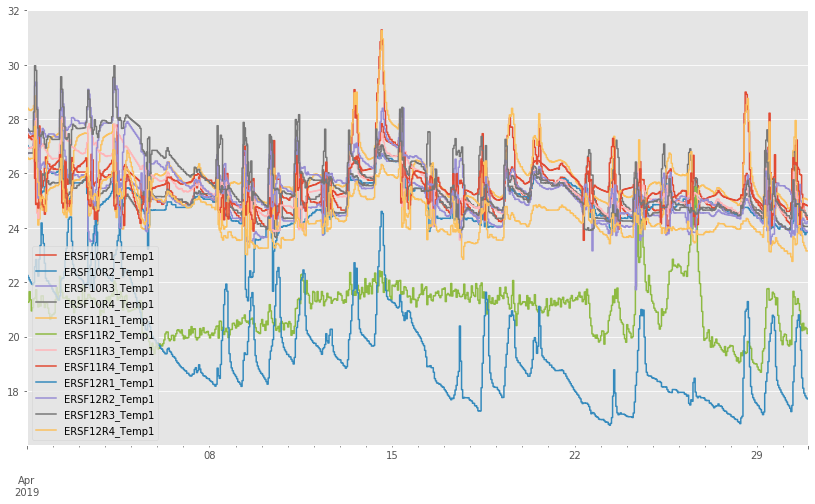

In [13]:
# Gerando o gráfico de tendência das temperaturas das salas
#fig, axes = plt.subplots(nrows=12, ncols=1, figsize=(18, 10))
nplots = 1 # ou 12!
fig_t, axes_t = plt.subplots(nrows=nplots, ncols=1, figsize=(14, 8))
_DF_.plot(drawstyle = 'steps', subplots=False, ax=axes_t)

In [14]:
# Gera Trendchart em base64 para vincular ao HTM
buffer_trend = io.BytesIO()
fig_t.savefig(buffer_trend, format='png', dpi=100)
buffer_trend.seek(0)
buffer_trend_base64 = base64.b64encode(buffer_trend.read()).decode()
print('Gráfico de tendência convertido para base64!!!')

Gráfico de tendência convertido para base64!!!


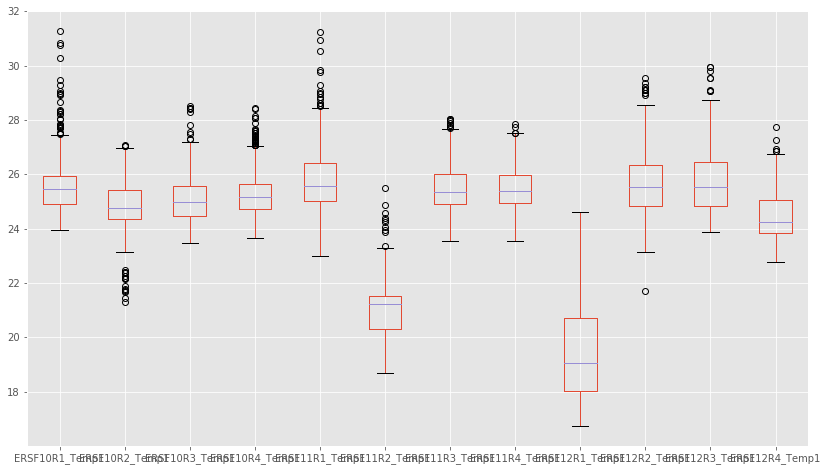

In [15]:
# Gerando o boxplot das temperaturas das salas
#fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(18, 10))
fig_b, axes_b = plt.subplots(nrows=1, ncols=1, figsize=(14, 8))
_DF_.boxplot(ax=axes_b)

In [16]:
# Gera Boxplot em base64 para vincular ao HTM
buffer_boxplot = io.BytesIO()
fig_b.savefig(buffer_boxplot, format='png', dpi=100)
buffer_boxplot.seek(0)
buffer_boxplot_base64 = base64.b64encode(buffer_boxplot.read()).decode()
print('Boxplot convertido para base64!!!')

Boxplot convertido para base64!!!


In [17]:
# GERA o Relatório em HTML - com a imagens vinculadas
file_loader = jinja2.FileSystemLoader('templates') # informa o diretório com os templates HTML
env = jinja2.Environment(loader=file_loader)
template_report = env.get_template('report.html') # carrega o template HTML
content_report = 'REPORT: Elipse Plant Manager - EPM Processor PDF Report example'
# Gera o relatório em HTML
html_report = template_report.render(content=content_report,
                                    img_string=image_file_path_to_base64_string('images/epmbanner.png'),
                                    img_trend=buffer_trend_base64,
                                    img_boxplot=buffer_boxplot_base64)

# Salva o relatório HTML no caminho previamente definido (em utf-8 -> caracteres especiais)
with open(report_file_html, 'w', encoding='utf-8') as html_file:
    html_file.write(html_report)
print(f'Relatório HTML gerado com sucesso: {report_file_html}')

Relatório HTML gerado com sucesso: C:\temp\HTMLReport_2019_08_29.html


In [18]:
# Converte o relatório de HTML para PDF - salvando na máquina local
pdf_file = pdfkit.from_string(html_report,
                              report_file_pdf,
                              configuration=config,
                              options=options, css='templates/paper_pdf.css')
if(pdf_file):
    print(f'Relatório PDF gerado com sucesso: {report_file_pdf}')

Relatório PDF gerado com sucesso: C:\temp\PDFReport_2019_08_29.pdf


In [19]:
# SEMPRE deve-se encerrar a conexão estabelecida com o EPM Server, pois isso irá encerrar a sessão e
# liberar a licença de EPM Client para que outros, eventualmente, possam utilizá-la.
epmConn.close()
print('Sessão encerrada com o EPM Server!!!')

Sessão encerrada com o EPM Server!!!


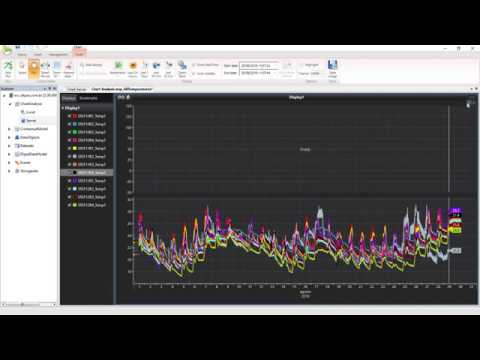

In [21]:
# Vídeo explicando este exemplo (https://www.youtube.com/c/MauricioPosser)
from IPython.lib.display import YouTubeVideo
YouTubeVideo('UET051DJ8hA')